In [124]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import my_functions
import importlib
importlib.reload(my_functions)
from my_functions import *

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

# DATA

In [125]:
data = pd.read_csv('stud_math.csv')

data.columns = ['school', 'sex', 'age', 'address', 'fam_size', 'p_status', 'm_edu', 'f_edu',
       'm_job', 'f_job', 'reason', 'guardian', 'travel_time', 'study_time',
       'failures', 'school_sup', 'fam_sup', 'paid', 'activities', 'nursery',
       'studytime_granular', 'higher', 'internet', 'romantic', 'fam_rel',
       'free_time', 'go_out', 'health', 'absences', 'score']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   fam_size            368 non-null    object 
 5   p_status            350 non-null    object 
 6   m_edu               392 non-null    float64
 7   f_edu               371 non-null    float64
 8   m_job               376 non-null    object 
 9   f_job               359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  travel_time         367 non-null    float64
 13  study_time          388 non-null    float64
 14  failures            373 non-null    float64
 15  school_sup          386 non-null    object 
 16  fam_sup 

In [126]:
data.head()

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,nursery,studytime_granular,higher,internet,romantic,fam_rel,free_time,go_out,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


# PRIMARY PROCESSING DATA

In [127]:
# Заменим в соотв. колонках слова YES и NO на бинарные значения 
data[['school_sup', 'fam_sup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']] = data[['school_sup', 'fam_sup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']].apply(yn_to_binary)

data

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,nursery,studytime_granular,higher,internet,romantic,fam_rel,free_time,go_out,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,-6.0,1.0,NaN,0.0,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,-6.0,1.0,1.0,0.0,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,1.0,0.0,NaN,0.0,1.0,-6.0,1.0,1.0,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0,-9.0,1.0,1.0,1.0,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,-6.0,1.0,0.0,0.0,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,-6.0,1.0,0.0,0.0,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0,1.0,0.0,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,0.0,0.0,0.0,0.0,-3.0,NaN,0.0,0.0,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,-3.0,1.0,1.0,0.0,4.0,4.0,1.0,5.0,0.0,50.0


# EDA

In [128]:
# посчитаем количество пустых значений по всем колонкам
data.apply(lambda x: x.isna().sum()).sort_values()

# Особенно выделяются колонки paid и p_status, где более 10% пустых значений

school                 0
sex                    0
age                    0
m_edu                  3
score                  6
studytime_granular     7
study_time             7
go_out                 8
school_sup             9
free_time             11
absences              12
activities            14
health                15
nursery               16
address               17
reason                17
m_job                 19
higher                20
failures              22
f_edu                 24
fam_rel               27
fam_size              27
travel_time           28
guardian              31
romantic              31
internet              34
f_job                 36
fam_sup               39
paid                  40
p_status              45
dtype: int64

## ЧИСЛОВЫЕ ПЕРЕМЕННЫЕ

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
45.0     27
70.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
NaN       6
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

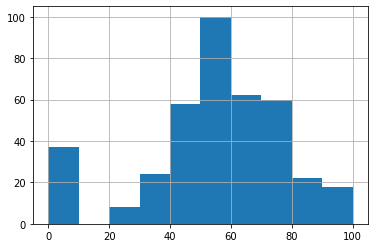

In [129]:
# Рассмотрим целевую колонку score
data.score.hist()
data.score.value_counts(dropna=False)

# Возможно, стоит учесть тот факт, что солидная часть оценок равна нулям (37 из 389 не пустых), т.е., возможно, студент совсем не сдал экзамен, либо даже не допустился, что может говорить о тотальном отставании в учебе по каким-либо причинам. В остальном оценки распределены более менее нормально.


16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64

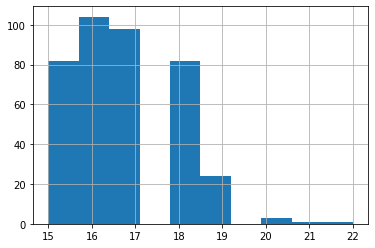

In [130]:
# колонка age : видим, что основная часть данных распределена между 15 и 18 годами
# небольбшая доля значений 19
# совсем небольшая доля выше 19, возможно, совсем незначительная
# Однако все значения не выходят за рамки выбросов 
data.age.hist()
data.age.value_counts(dropna=False)


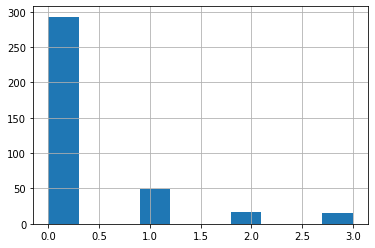

In [137]:
# Распределение неудач студентов сильно сдвинуто в сторону отсутствия неудач
data.failures.hist()

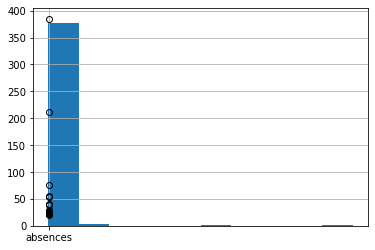

In [157]:
data.absences.hist()
boxplot = data.boxplot(column=['absences'])


# НОМИНАТИВНЫЕ ПЕРЕМЕННЫЕ

## большинство номинативных переменных имеют строго определенное количество уникальных значений от 2 до 5

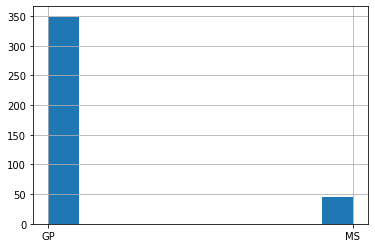

In [131]:
# Рассмотрим колонку school
data.school.hist()
# все данные поделены между двумя школами, причем по одной из них данных подавляющее количество

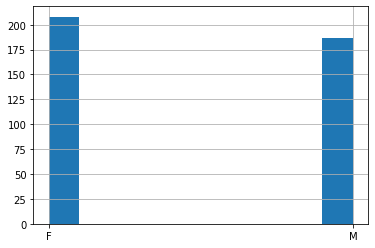

In [139]:
# по половому признаку студенты распределены нормально более-менее
data.sex.hist()

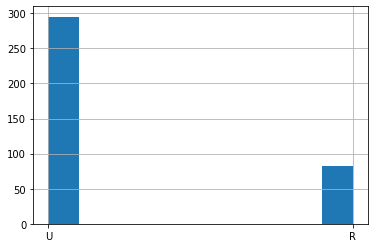

In [144]:
# Основная часть студентов городские
data.address.hist()

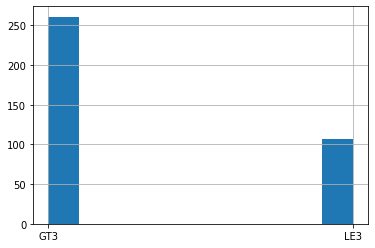

In [145]:
# Основная часть студентов живет в больших семьях
data.fam_size.hist()

In [142]:
# подавляющее большинство студентов живет с обоими родителями, так же значительное количество пустых значений
# Возможно, данный признак можно будет отбросить
data.p_status.value_counts(dropna=False)

T      314
NaN     45
A       36
Name: p_status, dtype: int64